#### Question 2 - [25 points] Ranked-Information Retrieval and Evaluation

In [1]:
# import files
from collections import defaultdict
import pandas as pd
from os import listdir
import os
from os.path import isfile, join
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer as ps
from nltk.stem import WordNetLemmatizer as wl
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
import re
import math
import seaborn as sns
import pandas as pd
stopword = set(stopwords.words())
import random
from sklearn.metrics import confusion_matrix ,  precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [2]:
#Reading Files

In [3]:
df = pd.read_csv('IR-assignment-2-data.txt',sep = " " , header = None)

In [4]:
df = (df.loc[df[1] == 'qid:4']).drop([138], axis=1) # selecting only qid:4
df

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,0,qid:4,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,...,127:27,128:2,129:9,130:124,131:4678,132:54,133:74,134:0,135:0,136:0
1,0,qid:4,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,127:61,128:0,129:8,130:122,131:508,132:131,133:136,134:0,135:0,136:0
2,0,qid:4,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,...,127:31,128:2,129:8,130:115,131:508,132:51,133:70,134:0,135:0,136:0
3,0,qid:4,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,127:32,128:82,129:17,130:122,131:508,132:83,133:107,134:0,135:10,136:13.35
4,1,qid:4,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,127:29,128:11,129:8,130:121,131:508,132:103,133:120,134:0,135:0,136:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0,qid:4,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,...,127:62,128:35,129:1,130:153,131:4872,132:9,133:55,134:0,135:0,136:0
99,1,qid:4,1:3,2:0,3:3,4:2,5:3,6:1,7:0,8:1,...,127:52,128:367,129:6,130:153,131:2383,132:18,133:99,134:0,135:16,136:11.3166666666667
100,2,qid:4,1:2,2:0,3:2,4:0,5:2,6:0.666667,7:0,8:0.666667,...,127:28,128:0,129:0,130:49182,131:26966,132:15,133:69,134:0,135:193,136:21.9355595468361
101,1,qid:4,1:2,2:0,3:2,4:0,5:2,6:0.666667,7:0,8:0.666667,...,127:23,128:0,129:1,130:42877,131:26562,132:12,133:24,134:0,135:56,136:62.9206042323688


1. Consider only the queries with qid:4 and the relevance judgement labels as relevance score.
2. (10 points) Make a file rearranging the query-url pairs in order of max DCG. State how many such
files could be made.

In [5]:
df_maxrel = df.copy(deep=True)
df_maxrel = df_maxrel.sort_values(by =0 , ascending = False)
df_maxrel =  df_maxrel.rename({0: 'Relevance score'}, axis='columns')
df_maxrel.to_csv('q2_part1.csv')

In [6]:
relevance_score = Counter(list(df_maxrel['Relevance score']))
print('Unique relevance scores:-' , relevance_score.keys())
print(relevance_score)

Unique relevance scores:- dict_keys([3, 2, 1, 0])
Counter({0: 59, 1: 26, 2: 17, 3: 1})


In [7]:
max_counts = 1
for i in relevance_score.values():
    max_counts *= math.factorial(i)
print("Total States = " , max_counts)

Total States =  19893497375938370599826047614905329896936840170566570588205180312704857992695193482412686565431050240000000000000000000000


3. (5 points) Compute nDCG
(a) At 50
(b) For the whole dataset

In [8]:
def ndgc(n):  # for calculating ndgc for n = numbers
    docs = list(df[0])[:n]
    dcg = 0
    for i in range(n):
        dcg += (docs[i]*1.0)/math.log2(i+2)
    docs.sort()
    docs.reverse()

    bdcg = 0
    for i in range(n):
        bdcg += (docs[i]*1.0)/math.log2(i+2)

    return dcg/bdcg

In [9]:
print("NDGC At 50 ", ndgc(50))
print("NDCG For the whole dataset" , ndgc(103))

NDGC At 50  0.5717260627203818
NDCG For the whole dataset 0.6357153091990775


4. (10 points) Assume a model that simply ranks URLs on the basis of the value of feature 75 (sum of
TF-IDF on the whole document) i.e. the higher the value, the more relevant the URL. Assume any
non zero relevance judgment value to be relevant. Plot a Precision-Recall curve for query “qid:4”.

In [10]:
for count, i in enumerate(df.iloc[:,76]): # getting td_idf score on the whole dataset 
    df.iloc[count, 76] = float(str(i).split(':')[1])

data1 = df.loc[:,[0,76]].sort_values(by = 76, ascending = False) 

#### ploting data

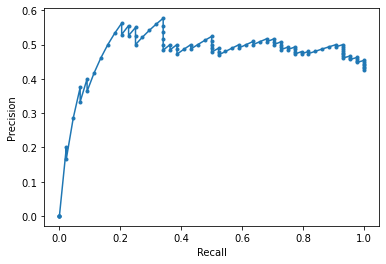

In [11]:
docs =  list(df[0])
relevant = 103 - docs.count(0)
total =103 # relevant + 0 relevance

rl = []
pl = []

rr = 0

for count, i in enumerate(data1.iloc[:,0]):
    if int(i) != 0:  # relevant
        rr = rr + 1

    recall = rr / relevant
    rl.append(recall)
    precision = rr / (count+1)
    pl.append(precision)   
        

from matplotlib import pyplot as py
py.plot(rl, pl, marker='.')
py.xlabel('Recall')
py.ylabel('Precision')
py.show()